# 🎬 高票房预测模型（使用 SVM / KNN / Voting 等）
基于 `train_movies.csv`, `validation_movies.csv`, `test_movies.csv`

In [2]:
!pip install catboost


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
)
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import warnings
warnings.filterwarnings("ignore")

train_df = pd.read_csv("train_movies.csv")
valid_df = pd.read_csv("validation_movies.csv")
test_df = pd.read_csv("test_movies.csv")

full_df = pd.concat([train_df, valid_df, test_df], ignore_index=True)

full_df['budget'] = pd.to_numeric(full_df['budget'], errors='coerce')
full_df['revenue'] = pd.to_numeric(full_df['revenue'], errors='coerce')
full_df['runtime'] = pd.to_numeric(full_df['runtime'], errors='coerce')
full_df['popularity'] = pd.to_numeric(full_df['popularity'], errors='coerce')
full_df['vote_average'] = pd.to_numeric(full_df['vote_average'], errors='coerce')
full_df['vote_count'] = pd.to_numeric(full_df['vote_count'], errors='coerce')

full_df['release_date'] = pd.to_datetime(full_df['release_date'], errors='coerce')
full_df['release_year'] = full_df['release_date'].dt.year

median_revenue = full_df['revenue'].median()
full_df['target'] = (full_df['revenue'] > median_revenue).astype(int)

features = ['budget', 'runtime', 'popularity', 'vote_average', 'vote_count', 'release_year']
full_df = full_df[features + ['target']].dropna()

train_len = len(train_df)
valid_len = len(valid_df)
test_len = len(test_df)

X_all = full_df[features]
y_all = full_df['target']

X_train = X_all[:train_len]
y_train = y_all[:train_len]
X_valid = X_all[train_len:train_len+valid_len]
y_valid = y_all[train_len:train_len+valid_len]
X_test = X_all[train_len+valid_len:]
y_test = y_all[train_len+valid_len:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)


In [4]:

models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    "LightGBM": LGBMClassifier(verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "NaiveBayes": GaussianNB(),
    "MLP": MLPClassifier(max_iter=300)
}


In [5]:

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)[:,1]
    else:
        y_prob = y_pred

    results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob)
    }

result_df = pd.DataFrame(results).T
display(result_df)


,accuracy,precision,recall,f1,roc_auc
RandomForest,0.915610,0.813358,0.624298,0.706397,0.926834
GradientBoosting,0.917437,0.819508,0.631320,0.713209,0.932496
XGBoost,0.915839,0.803177,0.639045,0.711772,0.931844
LightGBM,0.919379,0.820536,0.645365,0.722484,0.933692
CatBoost,0.918922,0.820467,0.641854,0.720252,0.933355
SVM,0.913897,0.863341,0.558989,0.678602,0.885364
KNN,0.907959,0.785055,0.597612,0.678628,0.871162
AdaBoost,0.913555,0.826002,0.593399,0.690642,0.926137
NaiveBayes,0.908987,0.798856,0.588483,0.677719,0.894999
MLP,0.917437,0.837344,0.610955,0.706456,0.931735


In [6]:

voting_clf = VotingClassifier(
    estimators=[
        ("rf", models["RandomForest"]),
        ("xgb", models["XGBoost"]),
        ("svm", models["SVM"]),
        ("mlp", models["MLP"]),
        ("knn", models["KNN"]),
    ],
    voting="soft"
)

voting_clf.fit(X_train_scaled, y_train)
y_pred_vote = voting_clf.predict(X_test_scaled)

print("VotingClassifier Accuracy:", accuracy_score(y_test, y_pred_vote))


VotingClassifier Accuracy: 0.9190361996117392


## 📌 Paper-Based Modeling (from: Predicting attributes based movie success through ensemble ML)

In [7]:

import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_train = pd.read_csv("train_movies.csv")
df_valid = pd.read_csv("validation_movies.csv")
df_test = pd.read_csv("test_movies.csv")
df_all = pd.concat([df_train, df_valid, df_test], ignore_index=True)

df_all['budget'] = pd.to_numeric(df_all['budget'], errors='coerce')
df_all['revenue'] = pd.to_numeric(df_all['revenue'], errors='coerce')
df_all['runtime'] = pd.to_numeric(df_all['runtime'], errors='coerce')
df_all['vote_average'] = pd.to_numeric(df_all['vote_average'], errors='coerce')
df_all['release_date'] = pd.to_datetime(df_all['release_date'], errors='coerce')
df_all['release_month'] = df_all['release_date'].dt.month
df_all['genre_main'] = df_all['genres'].str.extract(r"'name': '([^']+)'")

df_all['Hit_flop'] = np.where(df_all['revenue'] > df_all['budget'], 'Hit', 'Flop')

df = df_all[['budget', 'runtime', 'vote_average', 'release_month', 'genre_main', 'Hit_flop']].dropna()

df_encoded = pd.get_dummies(df, columns=['release_month', 'genre_main'], drop_first=True)

X = df_encoded.drop(columns=['Hit_flop'])
y = (df_encoded['Hit_flop'] == 'Hit').astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [8]:

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

models_paper = {
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "NaiveBayes": GaussianNB(),
    "RandomForest": RandomForestClassifier(),
    "MLP": MLPClassifier(max_iter=300),
    "GradientBoosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False)
}

voting_clf = VotingClassifier(
    estimators=[
        ('svm', models_paper["SVM"]),
        ('knn', models_paper["KNN"]),
        ('nb', models_paper["NaiveBayes"])
    ],
    voting='soft'
)
models_paper["VotingClassifier"] = voting_clf

results = {}
for name, model in models_paper.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    acc = np.mean(y_pred == y_test)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        "accuracy": acc,
        "roc_auc": auc,
        "conf_matrix": cm
    }

    print(f"📊 Model: {name}")
    print(f"Accuracy: {acc:.4f}, ROC AUC: {auc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print(classification_report(y_test, y_pred))
    print("="*50)


📊 Model: SVM
Accuracy: 0.8884, ROC AUC: 0.7848
Confusion Matrix:
[[7326   86]
 [ 870  282]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      7412
           1       0.77      0.24      0.37      1152

    accuracy                           0.89      8564
   macro avg       0.83      0.62      0.65      8564
weighted avg       0.88      0.89      0.86      8564

📊 Model: KNN
Accuracy: 0.8793, ROC AUC: 0.7402
Confusion Matrix:
[[7175  237]
 [ 797  355]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      7412
           1       0.60      0.31      0.41      1152

    accuracy                           0.88      8564
   macro avg       0.75      0.64      0.67      8564
weighted avg       0.86      0.88      0.86      8564

📊 Model: NaiveBayes
Accuracy: 0.5799, ROC AUC: 0.7504
Confusion Matrix:
[[4068 3344]
 [ 254  898]]
              precision    recall  f1-score   support

        

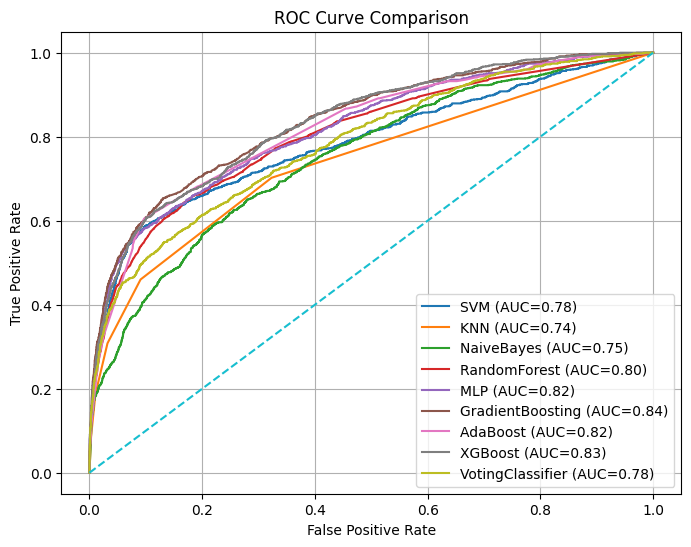

In [9]:

plt.figure(figsize=(8,6))
for name, model in models_paper.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        continue
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_proba):.2f})")

plt.plot([0,1], [0,1], linestyle='--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()
